In [8]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
sns.set_context('poster',font_scale=1.4)
import pandas as pd
import pyccl as ccl
from itertools import chain
from pprint import pprint
from math import fsum
import firecrown as fc

Populating the interactive namespace from numpy and matplotlib


# Creating Photo-z Distributions

## Source galaxy distribution

### Creating 5 bins with equal number of source galaxies

source sample: 5 redshift bins defined with equal numbers of source galaxies per bins

In [3]:
# getting the n(z) distribution from the LSSTDESC/Requirements github repo for Y10 and i+r bands. 
# only using this for source galaxy binning.

df = pd.read_csv('nzdist.txt', sep=' ') 
df.head()

,zmid,dn,dneff
0,0.05,0.107288,0.101795
1,0.15,0.600815,0.497371
2,0.25,1.233816,0.946778
3,0.35,2.521276,1.889779
4,0.45,3.350079,2.331543


In [4]:
zmid = df['zmid']
dneff = df['dneff']

# turn zmid, dneff pairs into a histogrammable dataset.
datapts = ([list(np.ones(int(dneff[i]/min(dneff)))*zmid[i]) for i in range(len(zmid))])
datapts = list(chain.from_iterable(datapts)) # flatten

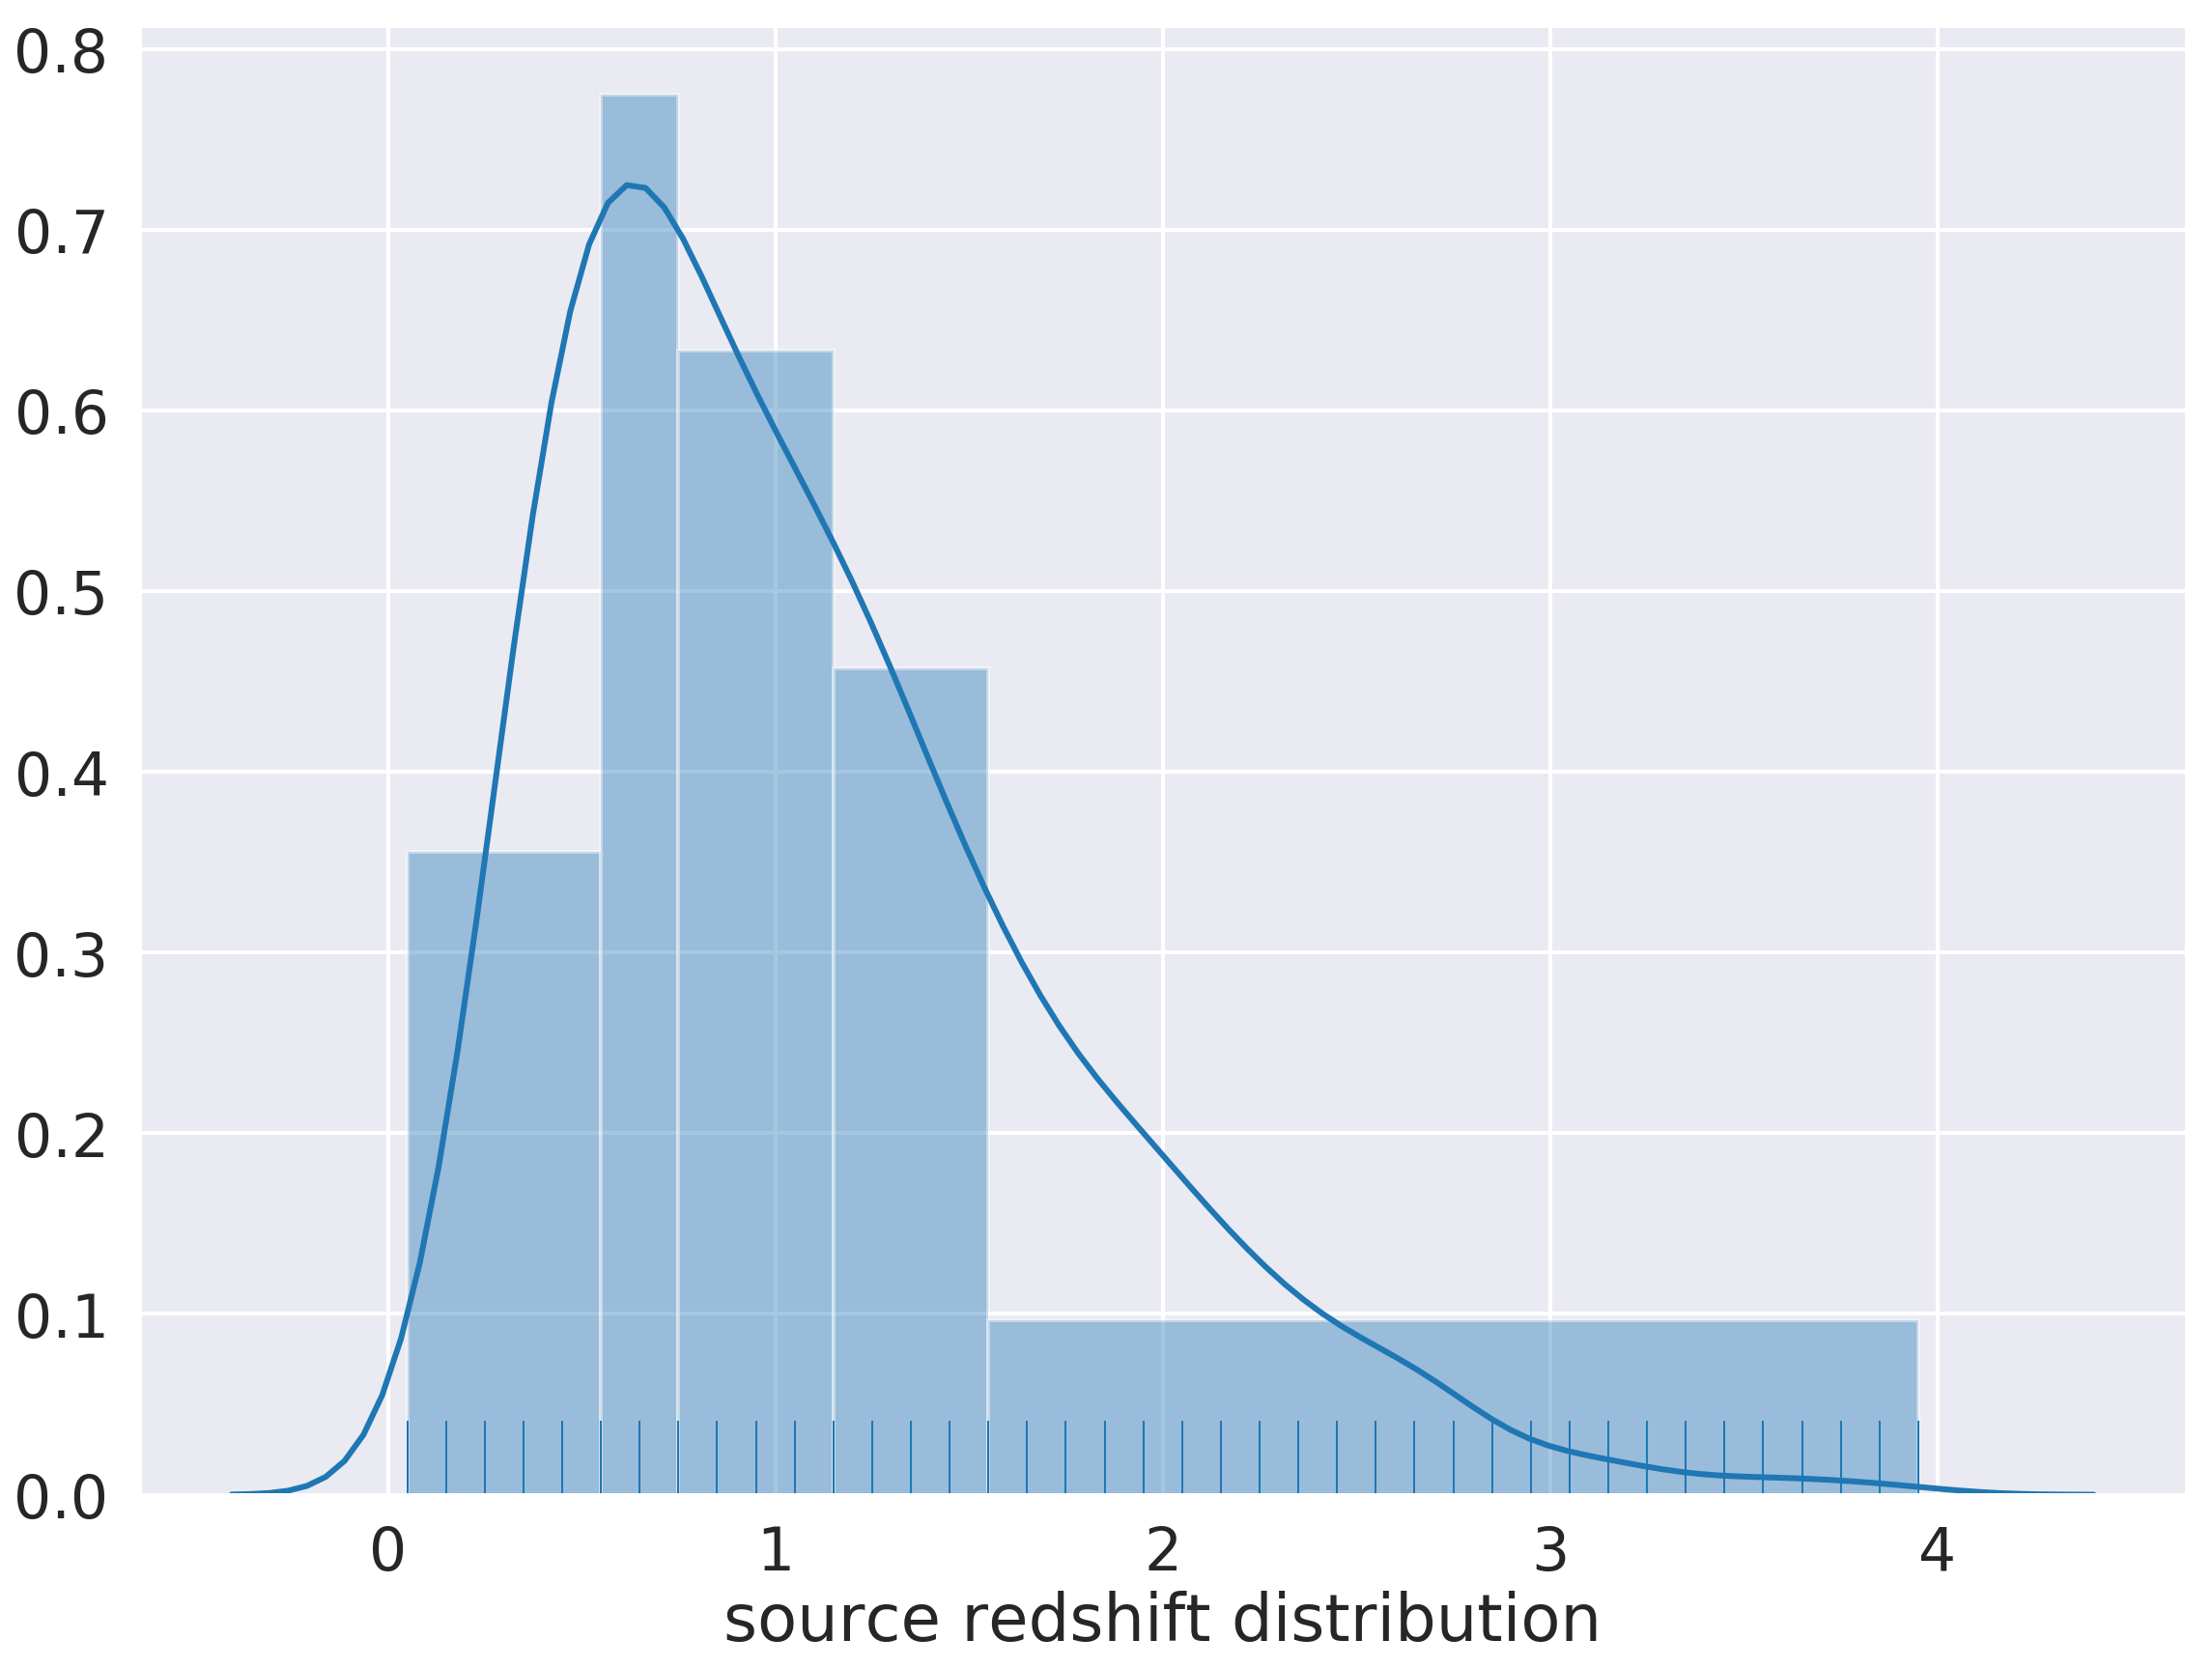

In [9]:
bins = datapts[0::int(len(datapts)/5)] # bin edges
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('source redshift distribution');

In [10]:
bin_centers = [.5*fsum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]

### Create source dN/dz distribution

In [11]:
ccl.dNdz_tomog?

Signature: ccl.dNdz_tomog(z, dNdz_type, zmin, zmax, pz_func)
Docstring:
Calculates dNdz in a particular tomographic bin, convolved
with a photo-z model (defined by the user), and normalized.

Args:
    z (float or array_like): Spectroscopic redshifts to evaluate dNdz at.
    dNdz_type (:obj:`str`): Type of redshift distribution.
    zmin (float): Minimum photo-z of the bin.
    zmax (float): Maximum photo-z of the bin.
    pz_func (callable): User-defined photo-z function.

Return:
    dNdz (float or array_like): dNdz values evalued at each z.
File:      ~/.local/lib/python3.6/site-packages/pyccl-0.10.dev180+g20f8b0fb-py3.6.egg/pyccl/lsst_specs.py
Type:      function


In [12]:
cosmo = ccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, sigma8=0.806, n_s=0.963)
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.05*(1+z_s)
    zbias  = 0.95/ccl.growth_rate(cosmo, 1/(1+z_s))
    return np.exp(- (z_ph - z_s - zbias)**2. / (2.*sigma_z**2.)) \
            * 1/np.sqrt(2*np.pi*sigma_z**2)

In [13]:
pz = ccl.PhotoZFunction(photoz)

In [14]:
z = np.linspace(0, 4, 121)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

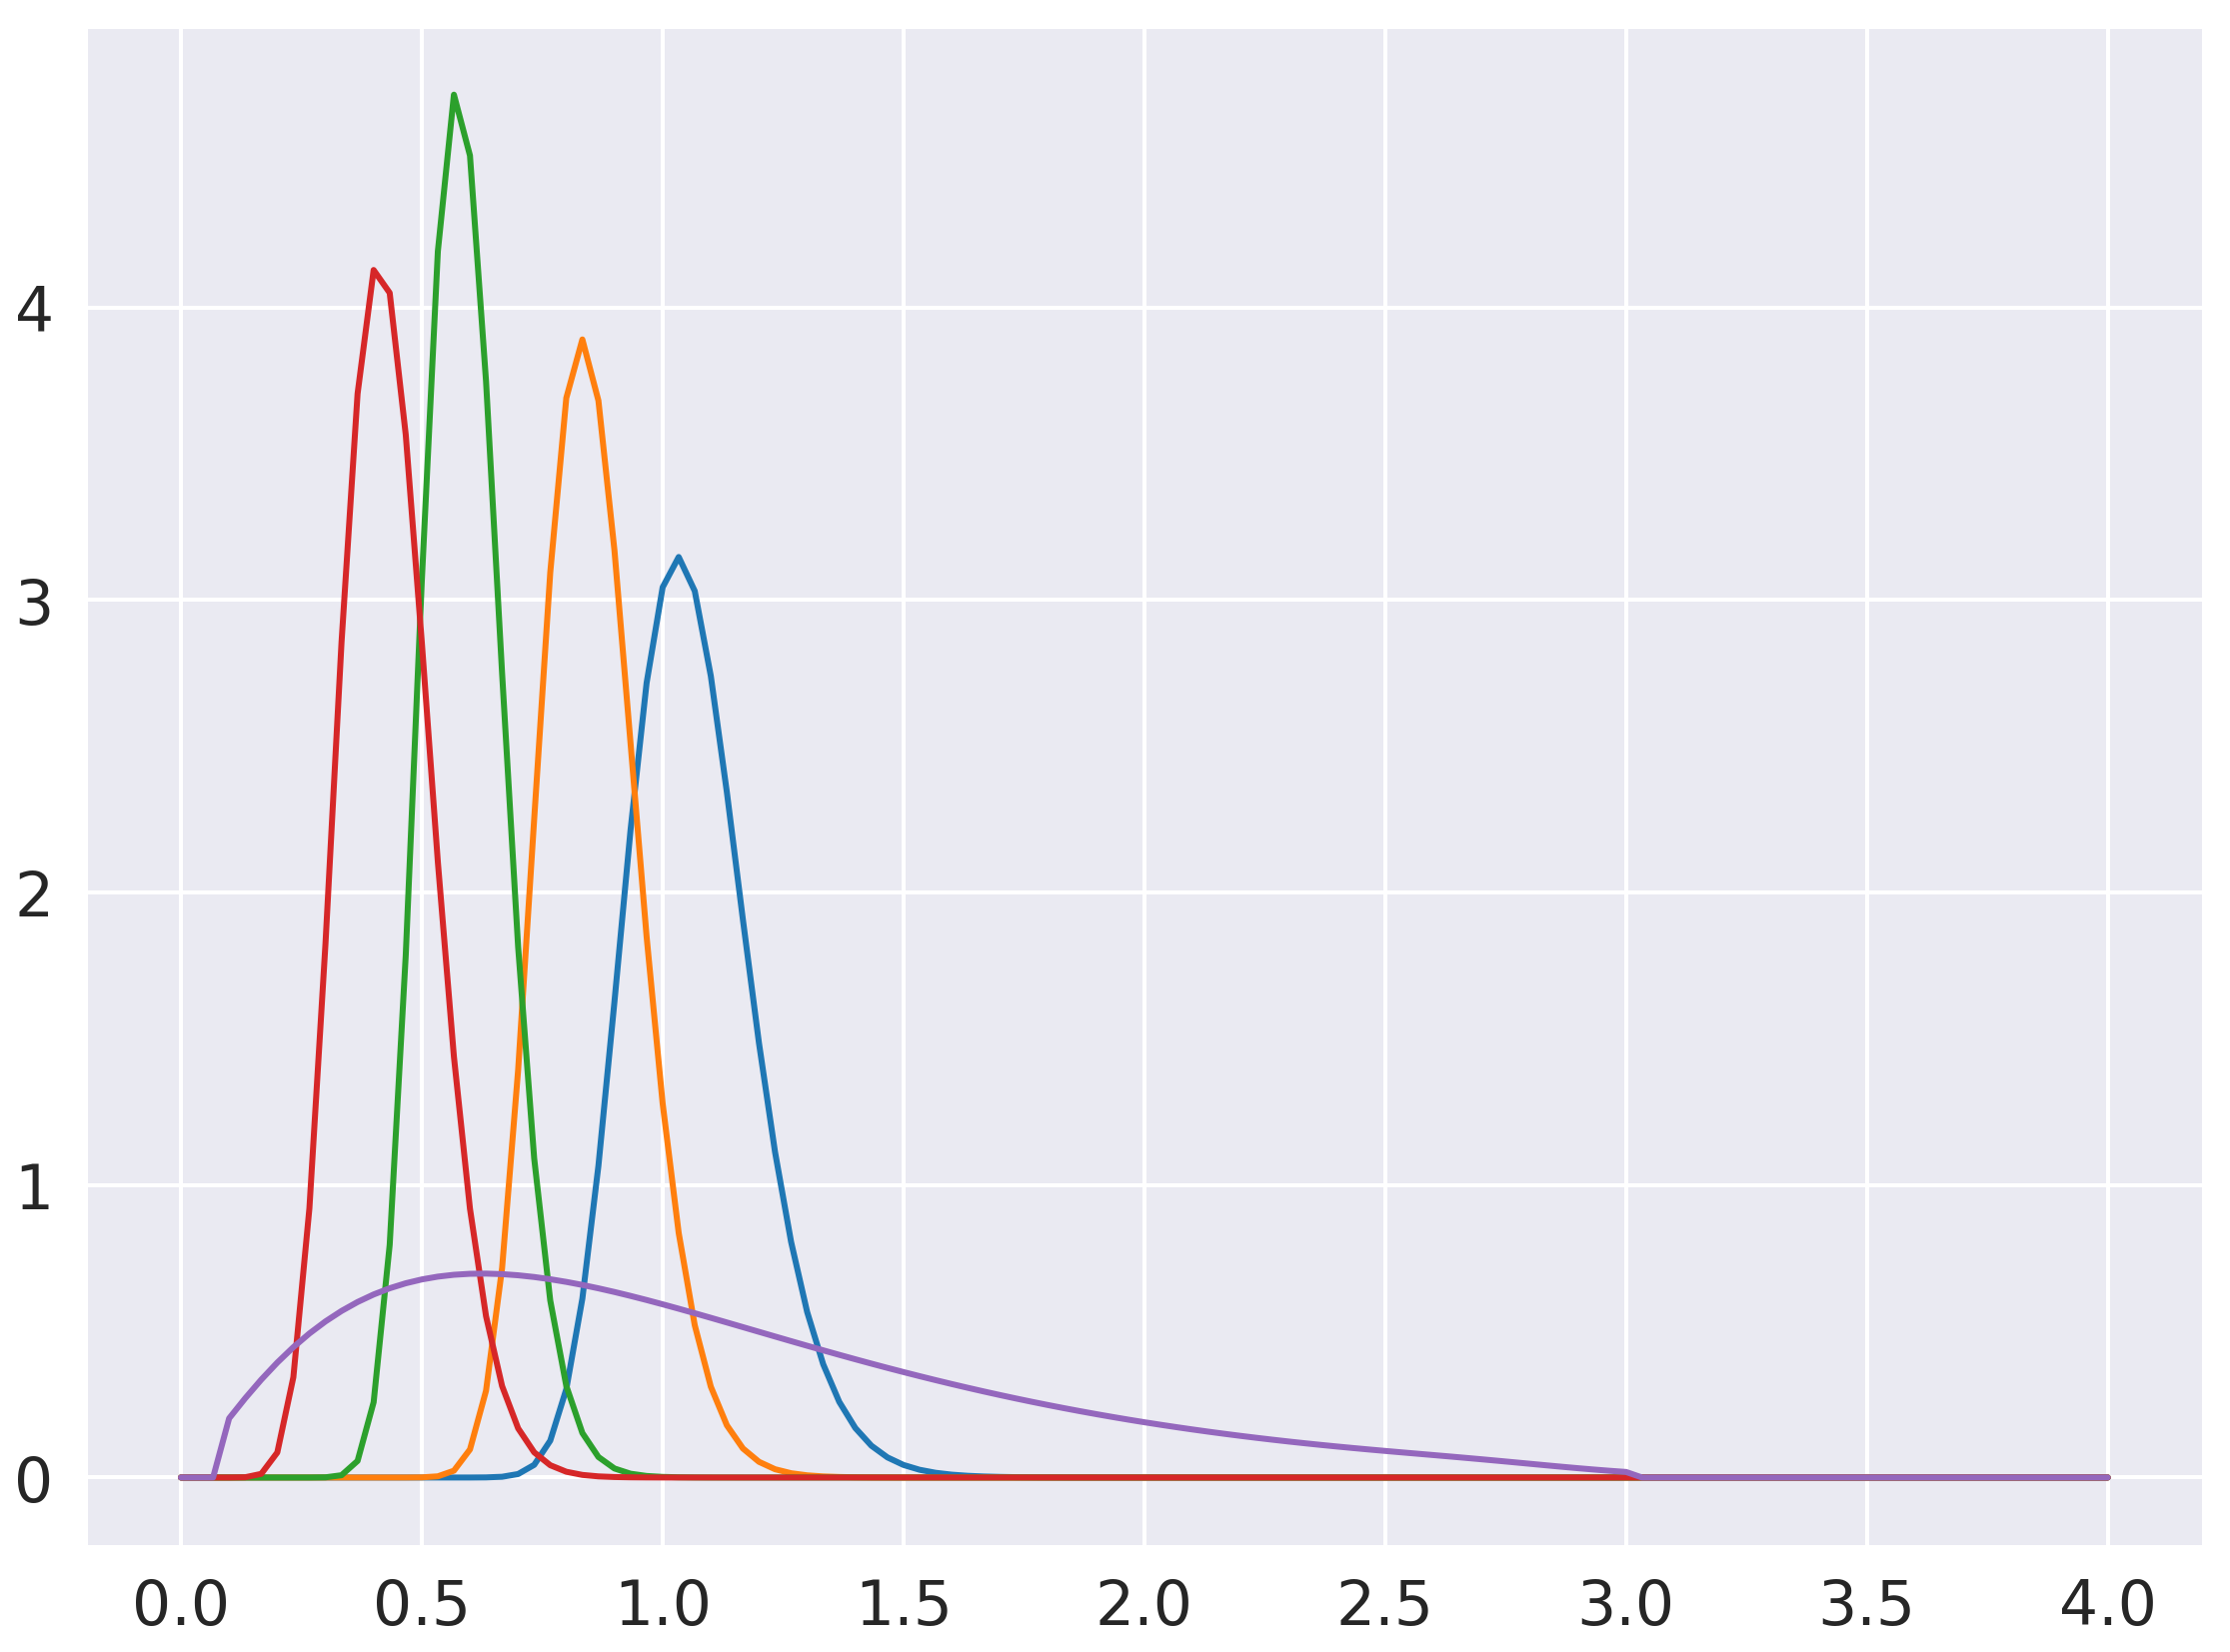

In [15]:
for key in dNdz_dict_source.keys():
    sns.lineplot(z, dNdz_dict_source[key], markers=False)

## Lens redshift distribution:

lens sample: 10 redshift bins spaced by 0.1 from 0.2 to 1.2

$$ \frac{dN}{dz} = z^2 exp (- (\frac{z}{z_0})^\alpha) $$
with $$z_0 = 0.28$$ and $$\alpha = 0.9$$
and bias $$ b(z) = 0.95/G(z)$$ and scatter $$ \sigma_z = 0.03 (1+z) $$

In [17]:
def dNdz_lens(z, alpha=0.9, simga=0.03, zscale=0.28, bias=0.95):
    return  48 * z**2 * np.exp(- (z/zscale)**alpha) 

### Define bins

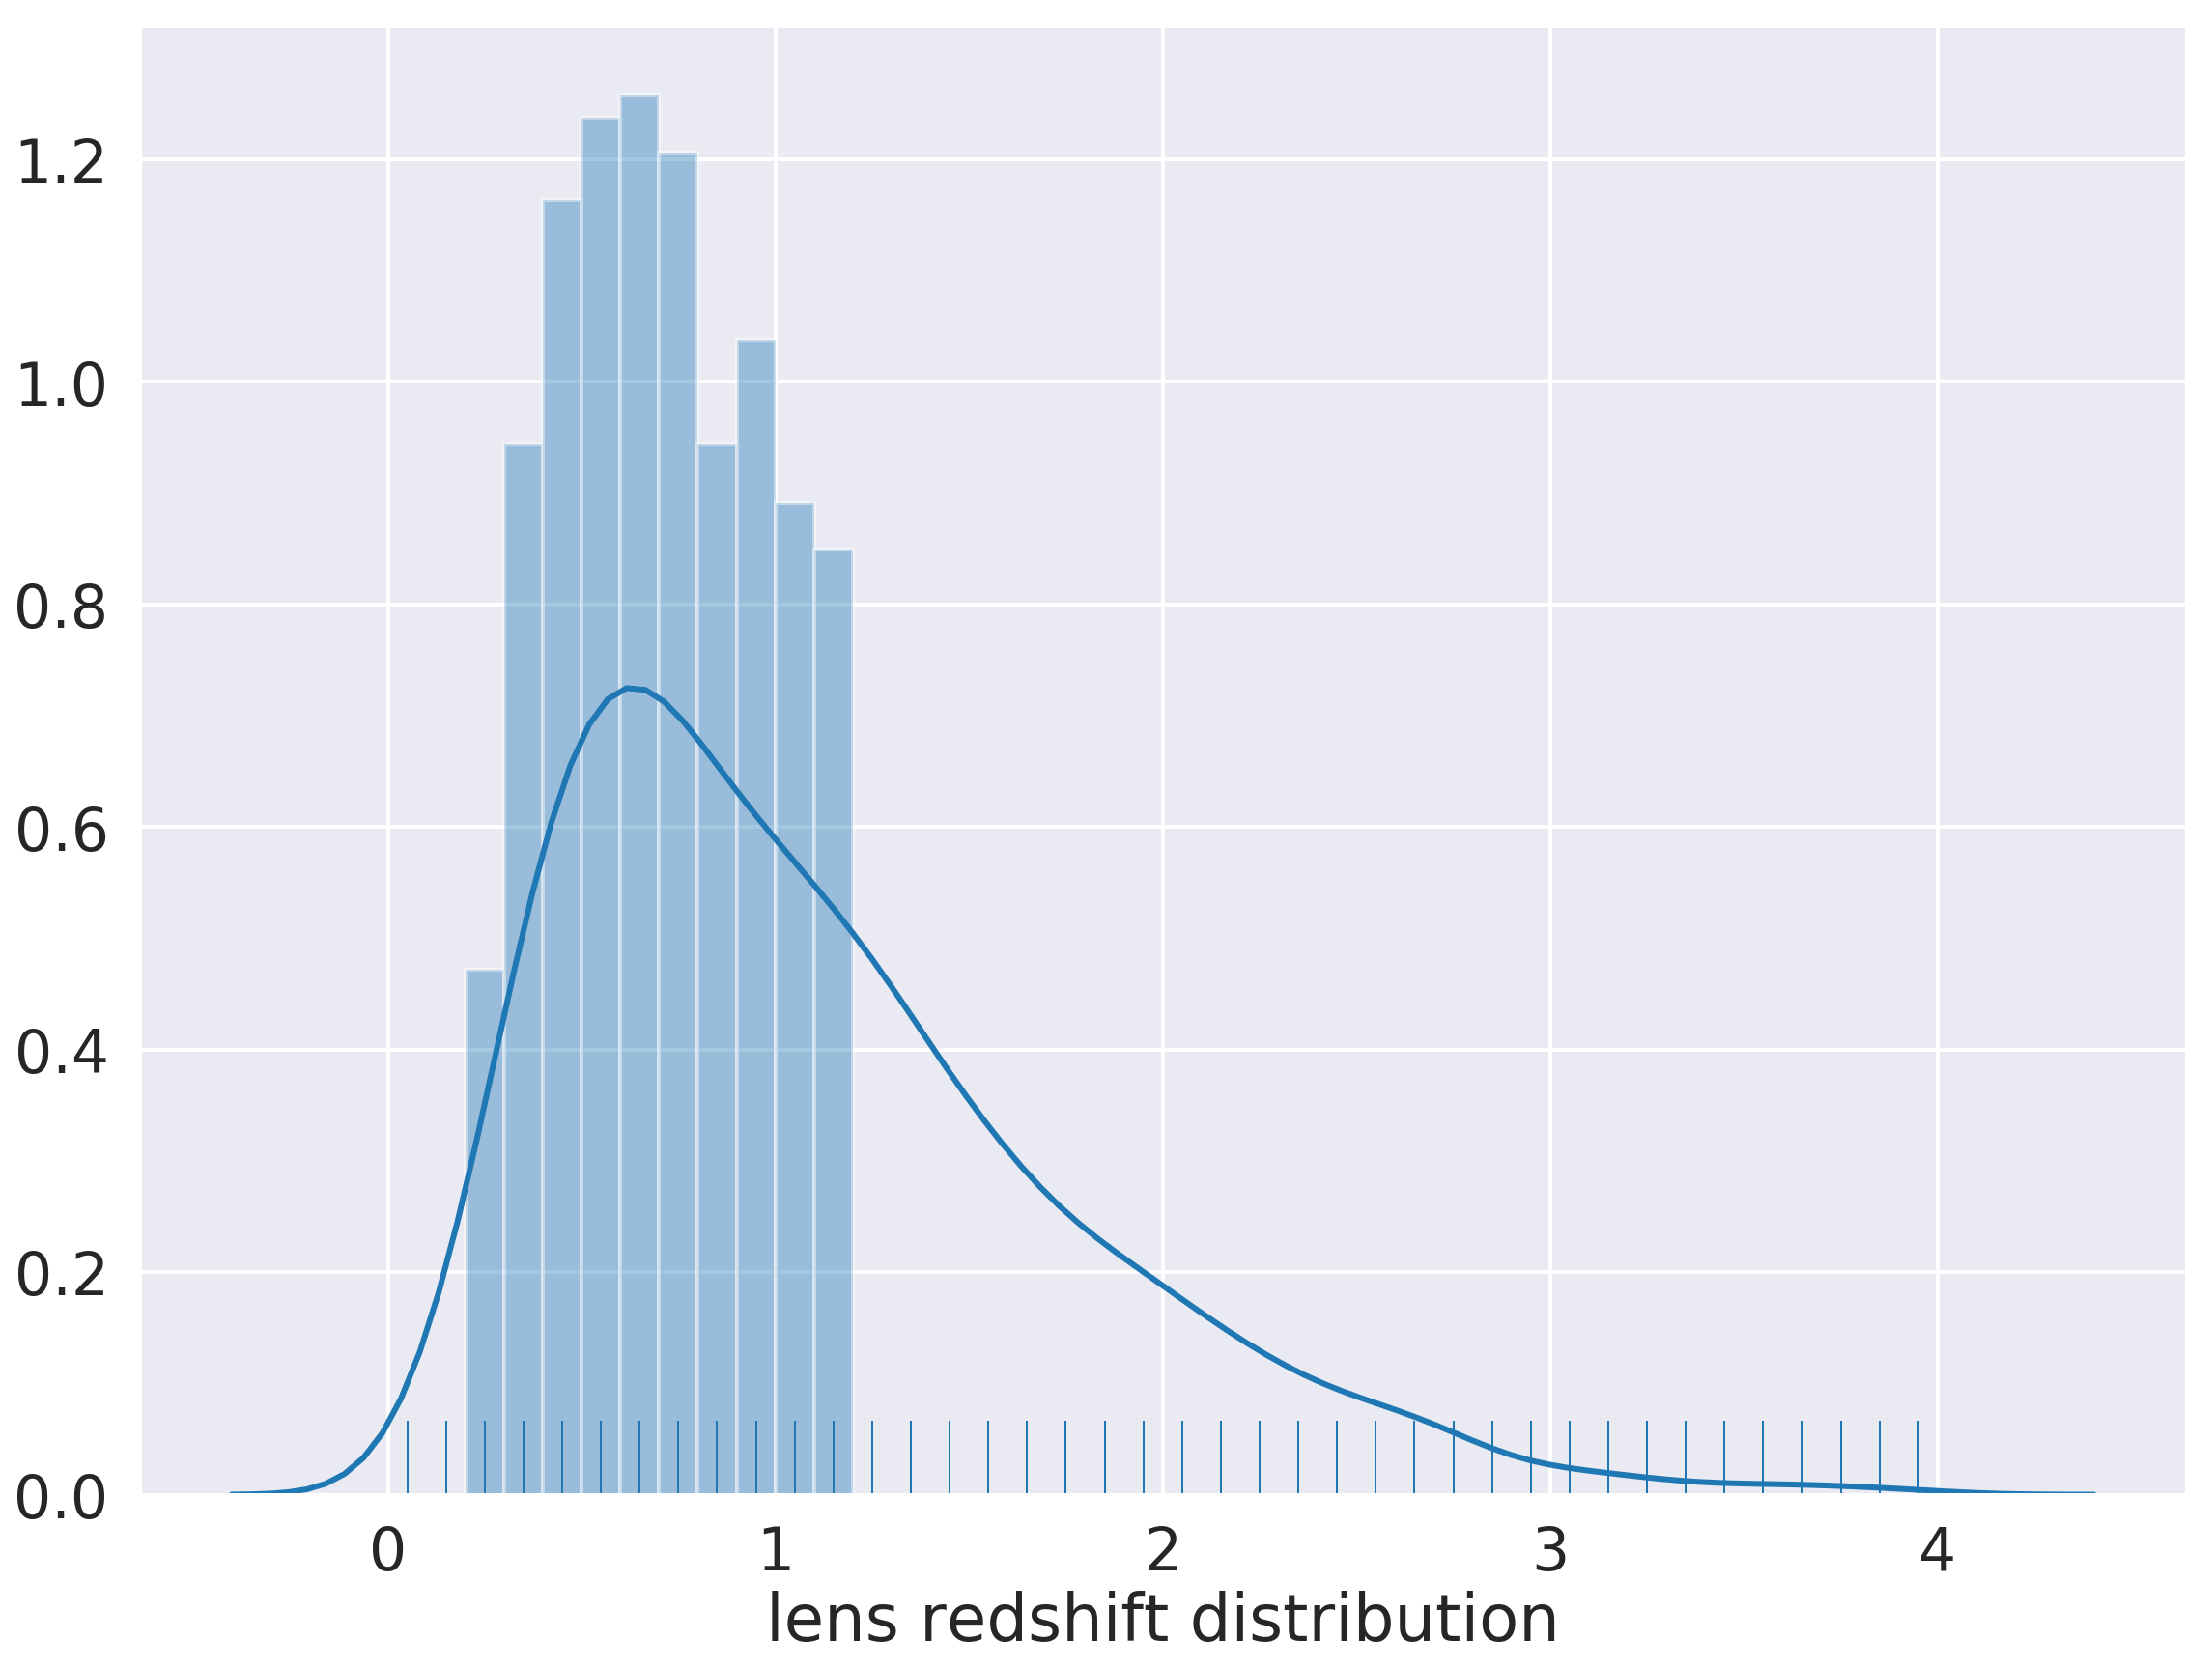

In [18]:
bins = np.linspace(0.2, 1.2, 11) # defines bin edges
z = np.linspace(0,2,21)
bin_centers = [fsum([bin+0.1]) for bin in bins][:-1]
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('lens redshift distribution');

### Creating Lens dN/dz distribution 

In [33]:
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.05*(1+z_s)
    zbias  = 0.95/ccl.growth_rate(cosmo, 1/(1+z_s))
    return np.exp(-(z_ph - z_s - zbias)**2 / (2*sigma_z**2)) \
            * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz) # creates 0.03 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_lens = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_lens[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)


Text(0,0.5,'n(z)')

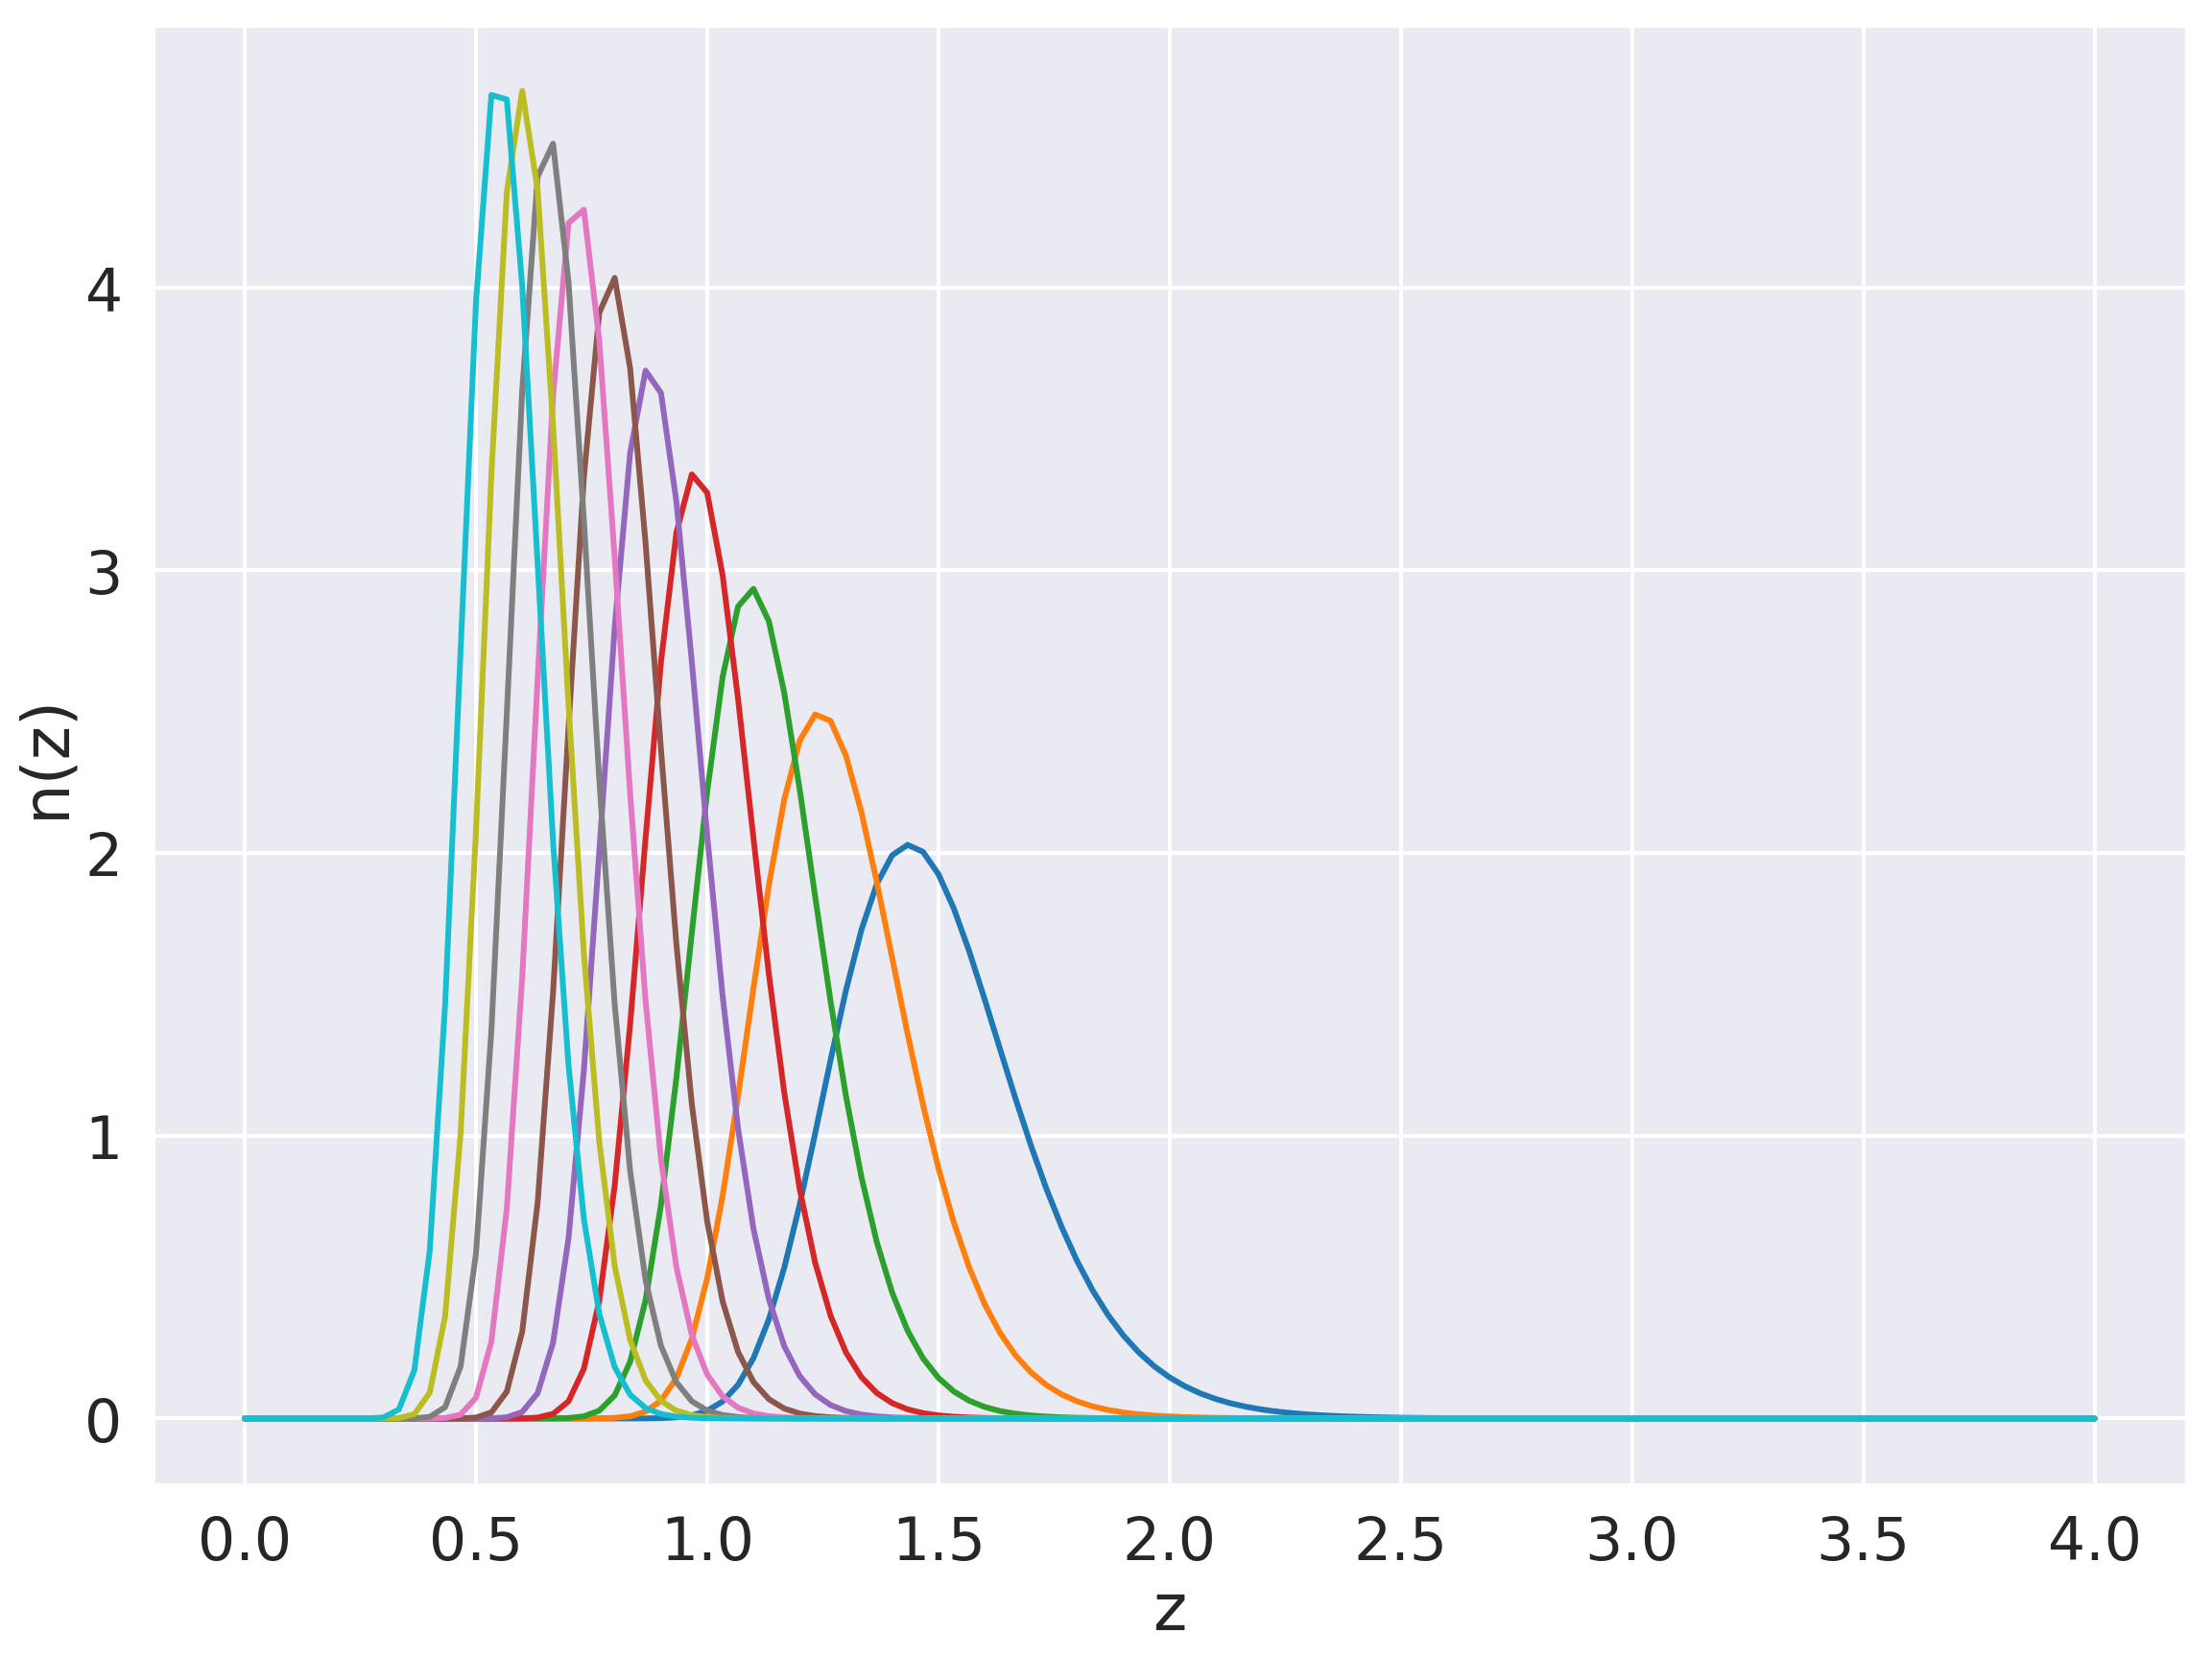

In [20]:
dNdz_lens_df = pd.DataFrame(dNdz_dict_lens)
for key in dNdz_lens_df.columns:
    sns.lineplot(x=z, y=dNdz_lens_df[key], data=dNdz_lens_df, markers=False)
plt.xlabel('z')
plt.ylabel('n(z)')

# Getting correlation functions from CCL

In [33]:
cosmo = ccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, sigma8=0.806, n_s=0.963)
pprint(cosmo)

pyccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, n_s=0.963, sigma8=0.806, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_class', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


## Getting shear and clustering tracers

In [132]:
dNdz_dict_lens.keys()

dict_keys([0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.7999999999999999, 0.9, 1.0000000000000002, 1.1, 1.2000000000000002])

In [35]:
dNdz_dict_source.keys()

dict_keys([0.30000000000000004, 0.65, 0.95, 1.35, 2.75])

In [133]:
D = ccl.growth_factor(cosmo, 1/(1+z))
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz_dict_source[0.1+0.2]))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz_dict_source[0.65]))
nc = ccl.NumberCountsTracer(cosmo, False, dndz=(z, dNdz_dict_lens[0.9]), bias=(z, 0.95/D)) # incoporate bias here

In [34]:
ell = np.arange(2, 2000)

dct = {}
zbin = 0
lst = list(dNdz_dict_source.keys())
for i, key in enumerate(lst):
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz_dict_source[key]))
    for keyj in lst[i:]:
        lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz_dict_source[keyj]))
        dct[zbin] = cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
        zbin+=1

### Check this by plotting shear-shear power spectra

In [40]:
# correlation function
# theta_deg = np.logspace(-1, 1, 40)
# xi_plus = ccl.correlation(cosmo, ell, cls, theta_deg, corr_type='L+', method='FFTLog')
# plotting_df = pd.DataFrame({
#     'theta (deg)': theta_deg,
#     'xi+': xi_plus
# })

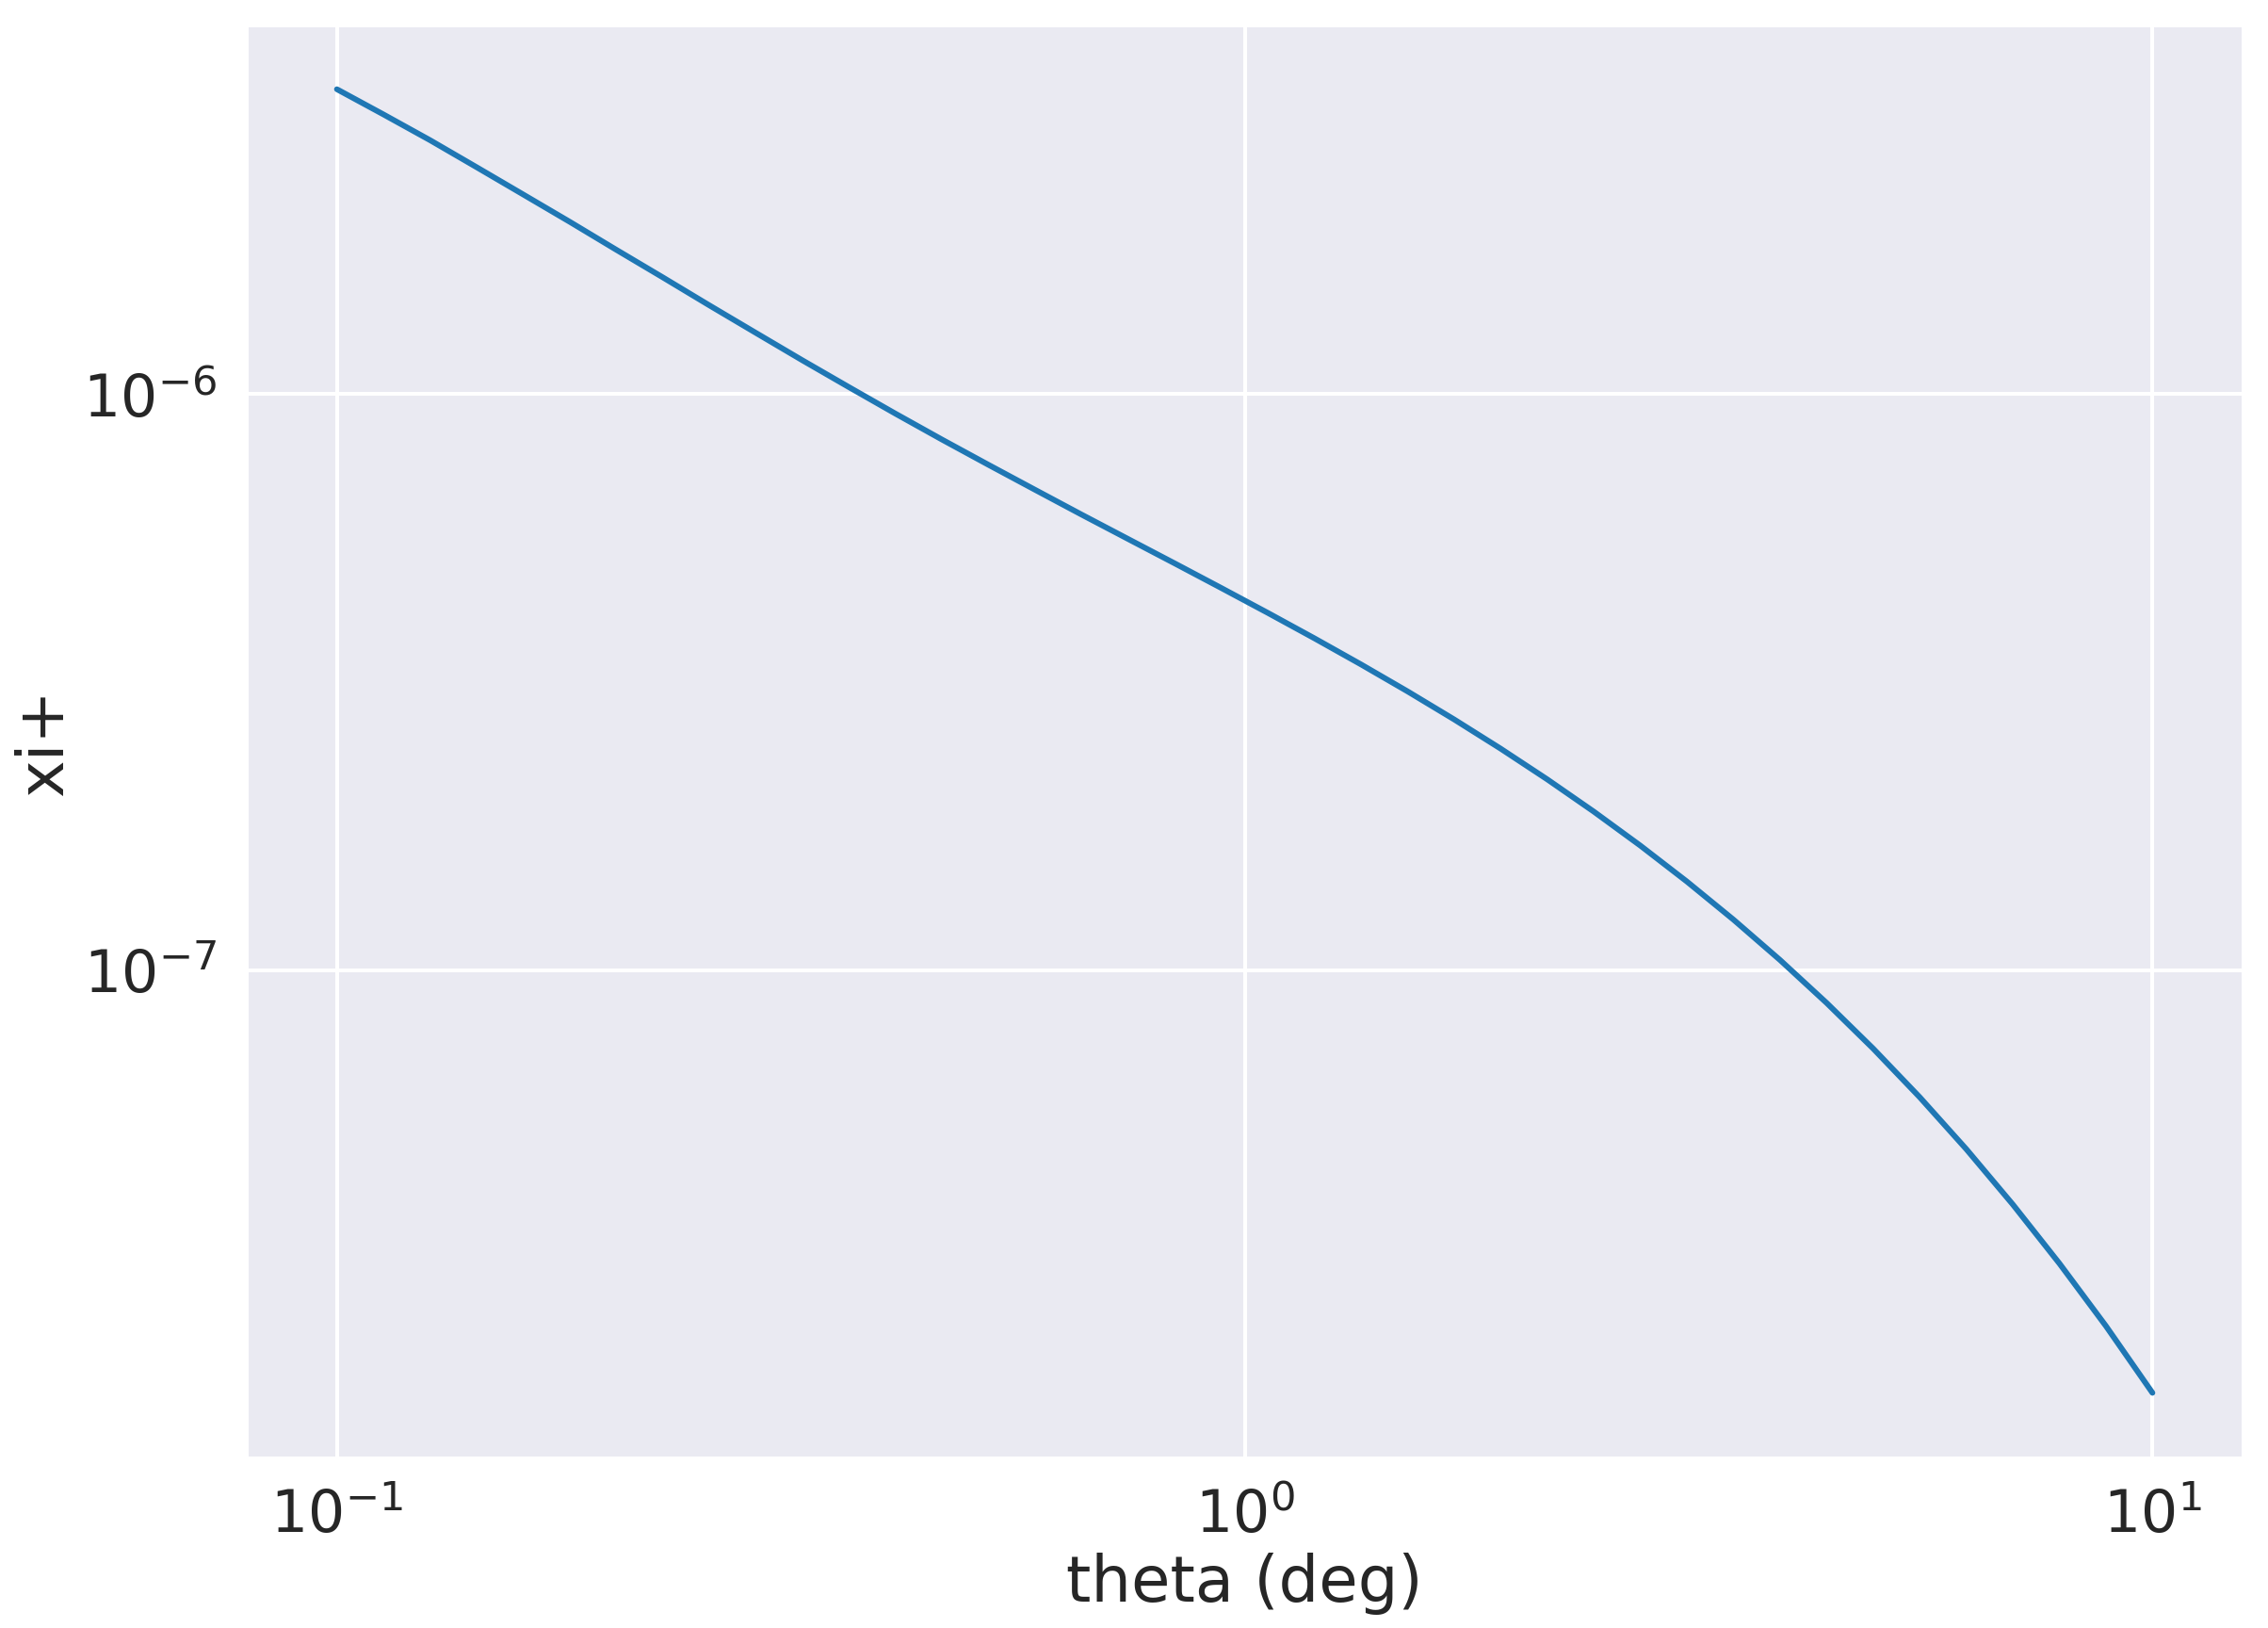

In [41]:
# sns.lineplot(x='theta (deg)', y='xi+', data=plotting_df)
# plt.xscale('log')
# plt.yscale('log')

## Comparing with DESC SRD data vectors

In [21]:
srd_ells = pd.read_csv('ell-values', names=['ell'])
srd_ss = pd.read_csv('shear_shear_Y10_fid', names=['C_ell'], delimiter=' ')
srd_ss['ell'] = list(srd_ells['ell'])*15
srd_ss['zbin'] = np.repeat(np.arange(0,15), 20)
srd_ss = srd_ss[srd_ss['ell']<3001]
srd_ss.head()

,C_ell,ell,zbin
0,3.946396e-09,23.59970,0
1,2.755755e-09,32.85940,0
2,1.856374e-09,45.75227,0
3,1.217820e-09,63.70386,0
4,7.999993e-10,88.69901,0


In [26]:
dct

{0: array([1.98352662e-08, 2.89386616e-08, 3.38896464e-08, ...,
        1.50767138e-10, 1.50662185e-10, 1.50557254e-10]),
 1: array([1.85462391e-08, 2.68133194e-08, 3.11530313e-08, ...,
        1.21556454e-10, 1.21469623e-10, 1.21382809e-10]),
 2: array([1.58706033e-08, 2.24402645e-08, 2.55679893e-08, ...,
        7.27448772e-11, 7.26892460e-11, 7.26336266e-11]),
 3: array([1.32767529e-08, 1.82890865e-08, 2.03692533e-08, ...,
        4.22226825e-11, 4.21882565e-11, 4.21538379e-11]),
 4: array([1.79506808e-08, 2.59280572e-08, 3.01225022e-08, ...,
        1.26720662e-10, 1.26631916e-10, 1.26543188e-10]),
 5: array([1.75015506e-08, 2.51094483e-08, 2.89805253e-08, ...,
        1.02312761e-10, 1.02238194e-10, 1.02163643e-10]),
 6: array([1.51985763e-08, 2.13730442e-08, 2.42397071e-08, ...,
        6.51392866e-11, 6.50889283e-11, 6.50385807e-11]),
 7: array([1.28313728e-08, 1.76010765e-08, 1.95338629e-08, ...,
        3.89155713e-11, 3.88836112e-11, 3.88516577e-11]),
 8: array([1.68404612e-0

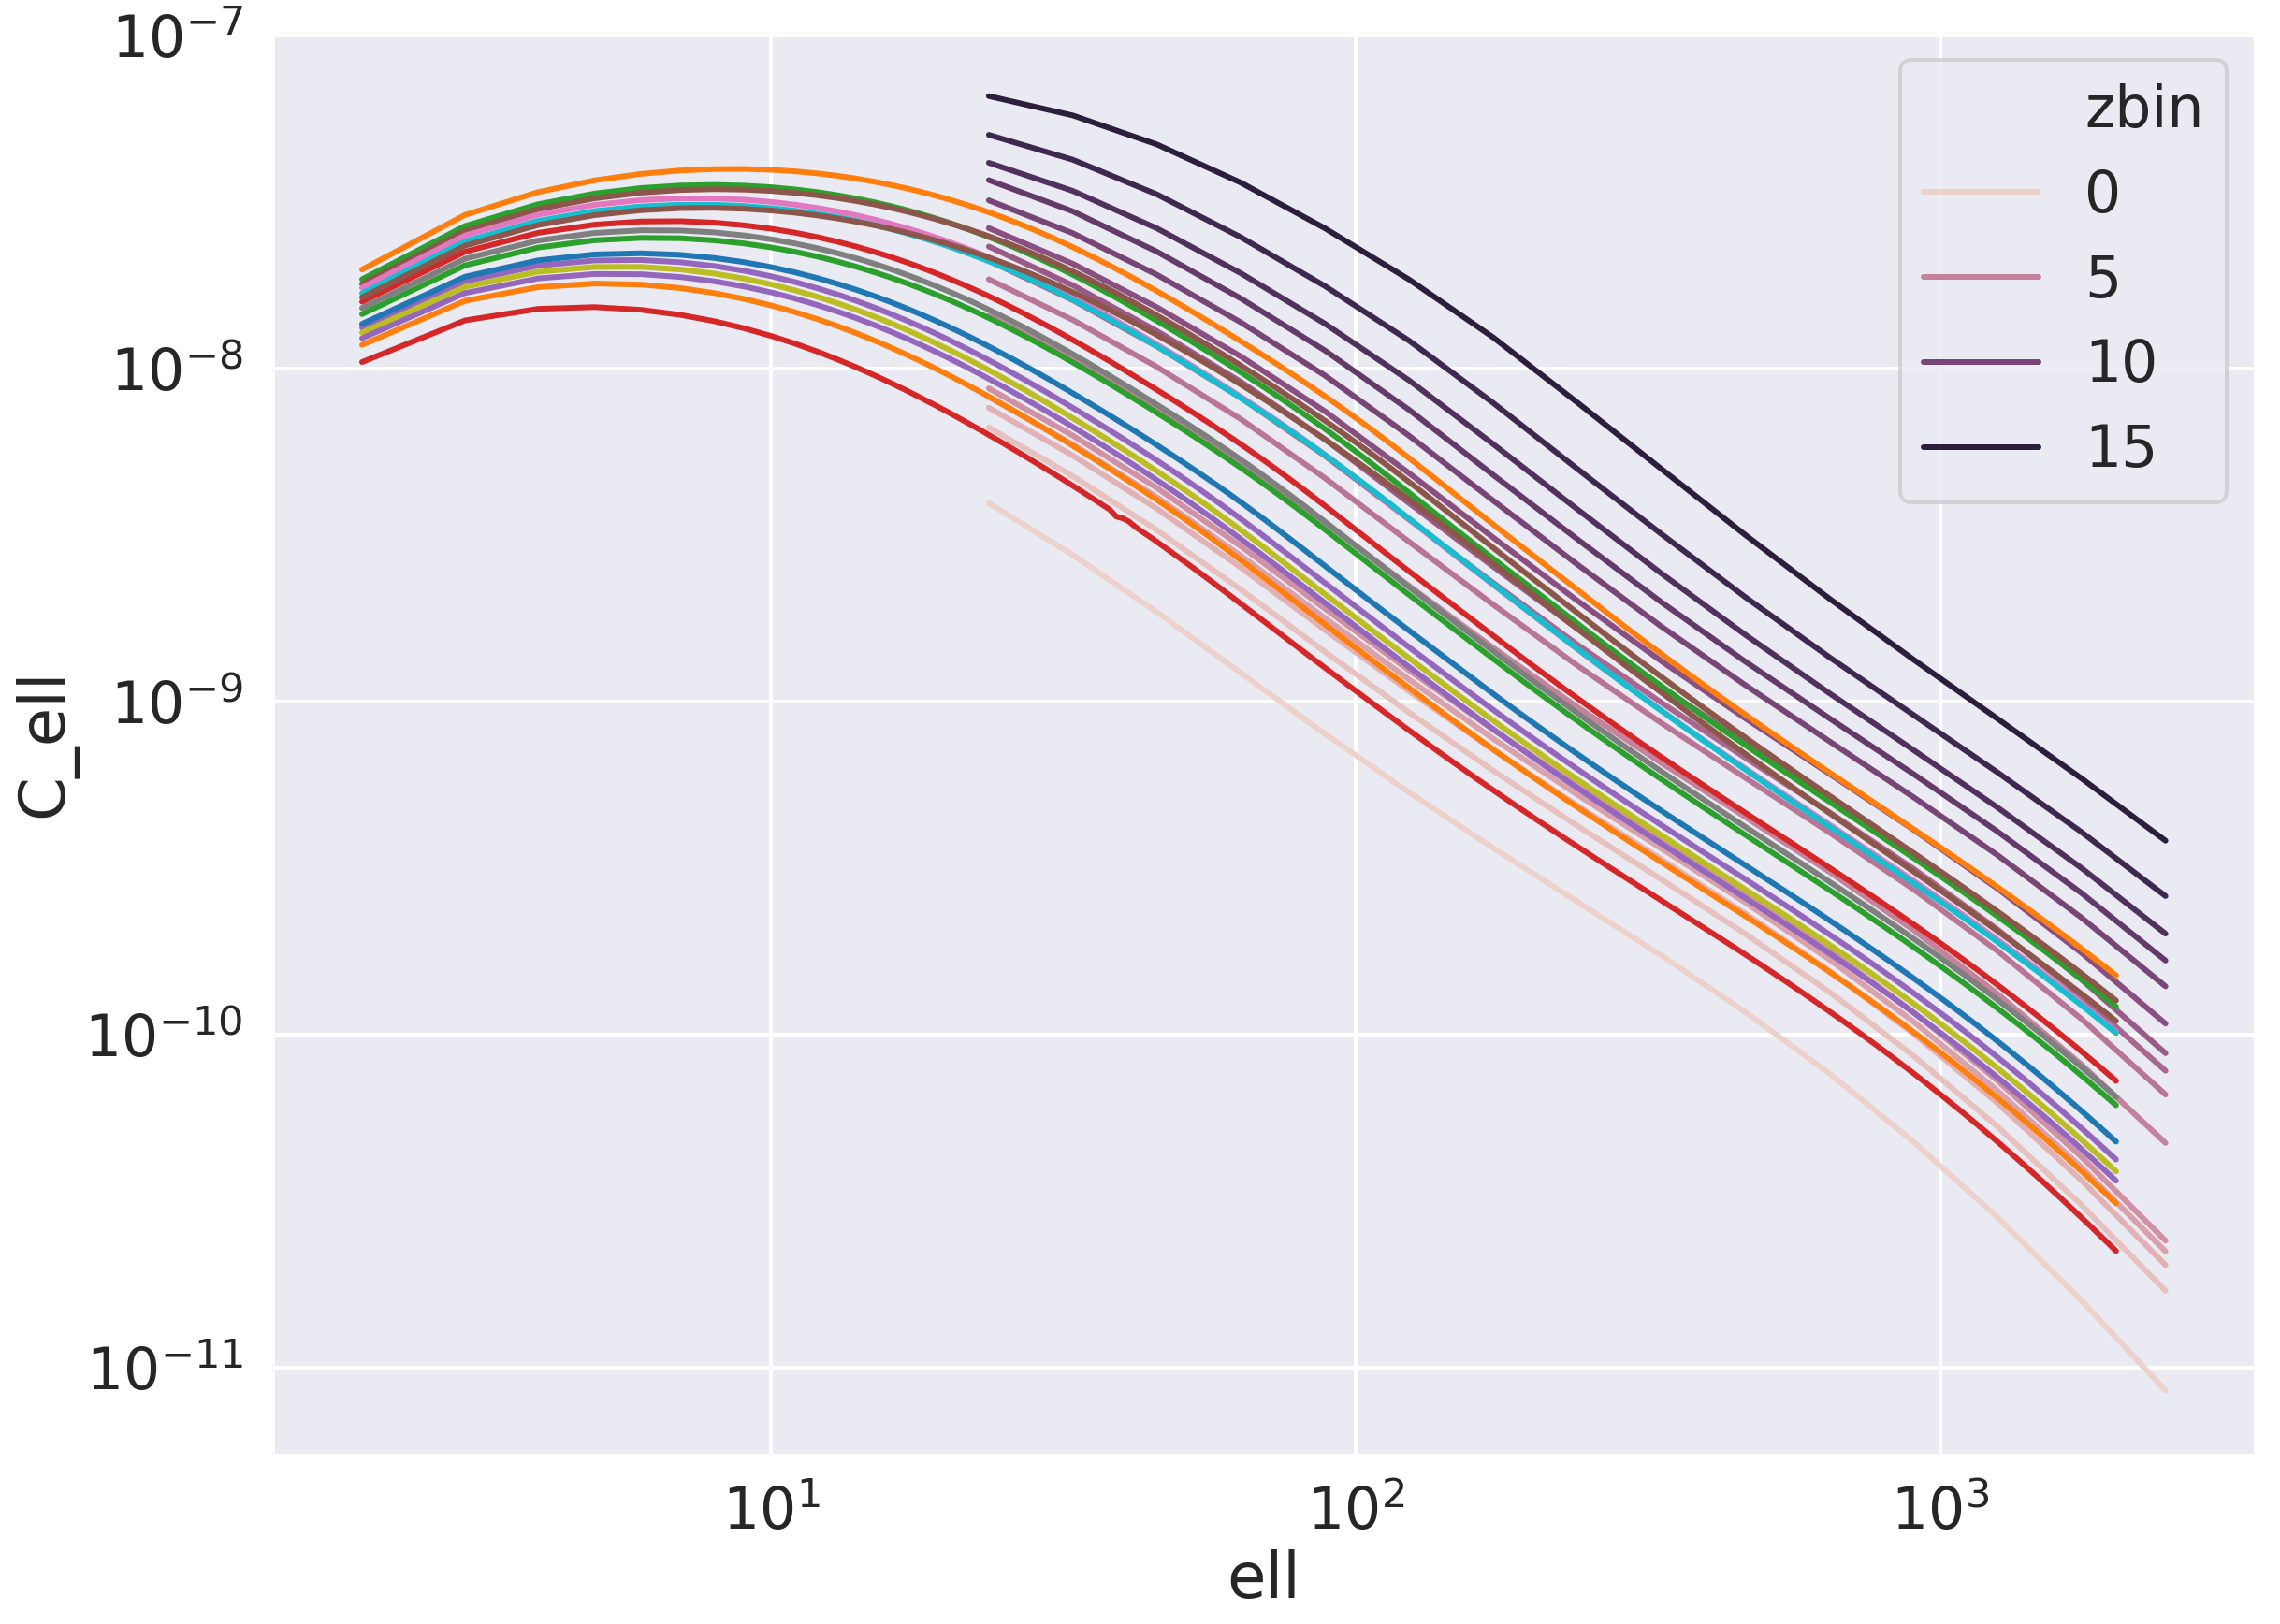

In [35]:
sns.lineplot('ell', 'C_ell', data=srd_ss, hue='zbin');
for i in range(15):
    sns.lineplot(x=ell, y=dct[i])
plt.yscale('log')
plt.xscale('log')

# Running Cosmosis via Firecrown

In [142]:
fc.run_cosmosis?

Signature: fc.run_cosmosis(config, data)
Docstring:
Run CosmoSIS on the problem.

This requires the following parameters 'sampler' section
of the config:

  sampler - name of sampler to use, e.g. emcee, multinest, grid, ...
  output - name of file to save to

Parameters
----------
config : dict
    Configuration info, usually read directly from the YAML file

data : dict
    The result of calling `firecrown.config.parse` on an input YAML
    config.
File:      ~/.local/lib/python3.6/site-packages/firecrown/cosmosis/run.py
Type:      function


## Writing out config.yaml file for firecrown to call cosmosis on

### Write out n(z) to csv

In [156]:
df = pd.DataFrame({'z': z, 'nz': dNdz_dict_lens[0.1+0.2]})
df.to_csv('pz.csv', index=False)

### Create a toy data vectors

In [170]:
tracers = [lens1, lens2, nc]

dv = []
ndv = []

for i in range(len(tracers)):
    for j in range(i, len(tracers)):
        pell = ccl.angular_cl(cosmo, tracers[i], tracers[j], ell)
        npell = pell + np.random.normal(size=pell.shape[0]) * 0.01 * pell

        df = pd.DataFrame({'l': ell, 'cl': npell})
        df.to_csv('cl{}{}.csv'.format(i, j), index=False)
        dv.append(pell)
        ndv.append(npell)


### Create a fake covariance matrix

In [ ]:
dv = np.concatenate(dv, axis=0)
ndv = np.concatenate(ndv, axis=0)

nelts = len(tracers) * (len(tracers) + 1) // 2

cov = np.identity(len(pell) * nelts)

for i in range(len(dv)):
    cov[i, i] *= (0.01 * dv[i]) ** 2
_i = []
_j = []
_val = []
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        _i.append(i)
        _j.append(j)
        _val.append(cov[i, j])

df = pd.DataFrame({'i': _i, 'j': _j, 'cov': _val})
df.to_csv('cov.csv', index=False)

### Write out .yaml file

In [177]:
%%file config.yaml

parameters:
  Omega_k: 0.0
  Omega_c: 0.27
  Omega_b: 0.045
  h: 0.67
  n_s: 0.96
  sigma8: 0.8
  w0: -1.0
  wa: 0.0
  src0_delta_z: 0.0
  src1_delta_z: 0.0
two_point:
  module: firecrown.ccl.two_point
  sources:
    src0:
      kind: WLSource
      nz_data: pz.csv
      has_intrinsic_alignment: False
      systematics:
        - pz_delta_0
  systematics:
    pz_delta_0:
      kind: PhotoZShiftBias
      delta_z: src0_delta_z
  likelihood:
    kind: ConstGaussianLogLike
    data: cov.csv
    data_vector:
      - cl_src0_src0
      - cl_src0_src1
      - cl_src1_src1
  statistics:
    cl_src0_src0:
      sources: ['src0', 'src0']
      kind: 'cl'
      data: cl00.csv
    cl_src0_src1:
      sources: ['src0', 'src1']
      kind: 'cl'
      data: cl01.csv
    cl_src1_src1:
      sources: ['src1', 'src1']
      kind: 'cl'
      data: cl11.csv


Overwriting config.yaml


## Run cosmosis

In [5]:
config, data = fc.parse('config.yaml')

In [6]:
config

{'parameters': {'Omega_k': 0.0,
  'Omega_c': 0.27,
  'Omega_b': 0.045,
  'h': 0.67,
  'n_s': 0.96,
  'sigma8': 0.8,
  'w0': -1.0,
  'wa': 0.0,
  'src0_delta_z': 0.0,
  'src1_delta_z': 0.0},
 'two_point': {'module': 'firecrown.ccl.two_point',
  'sources': {'src0': {'kind': 'WLSource',
    'nz_data': 'pz.csv',
    'has_intrinsic_alignment': False,
    'systematics': ['pz_delta_0']}},
  'systematics': {'pz_delta_0': {'kind': 'PhotoZShiftBias',
    'delta_z': 'src0_delta_z'}},
  'likelihood': {'kind': 'ConstGaussianLogLike',
   'data': 'cov.csv',
   'data_vector': ['cl_src0_src0', 'cl_src0_src1', 'cl_src1_src1']},
  'statistics': {'cl_src0_src0': {'sources': ['src0', 'src0'],
    'kind': 'cl',
    'data': 'cl00.csv'},
   'cl_src0_src1': {'sources': ['src0', 'src1'],
    'kind': 'cl',
    'data': 'cl01.csv'},
   'cl_src1_src1': {'sources': ['src1', 'src1'],
    'kind': 'cl',
    'data': 'cl11.csv'}}}}

In [11]:
data

{'parameters': {'Omega_k': 0.0,
  'Omega_c': 0.27,
  'Omega_b': 0.045,
  'h': 0.67,
  'n_s': 0.96,
  'sigma8': 0.8,
  'w0': -1.0,
  'wa': 0.0,
  'src0_delta_z': 0.0,
  'src1_delta_z': 0.0},
 'two_point': {'data': {'statistics': {'cl_src0_src0': <firecrown.ccl.statistics.two_point.TwoPointStatistic at 0x2b1b0bc91198>,
    'cl_src0_src1': <firecrown.ccl.statistics.two_point.TwoPointStatistic at 0x2b1ad7a4f668>,
    'cl_src1_src1': <firecrown.ccl.statistics.two_point.TwoPointStatistic at 0x2b1ad781a3c8>},
   'sources': {'src0': <firecrown.ccl.sources.sources.WLSource at 0x2b1ad7803438>},
   'likelihood': <firecrown.ccl.likelihoods.gaussian.ConstGaussianLogLike at 0x2b1b03bc1278>,
   'systematics': {'pz_delta_0': <firecrown.ccl.systematics.pz.PhotoZShiftBias at 0x2b1adba781d0>}},
  'eval': <function firecrown.ccl.two_point.compute_loglike(*, cosmo, parameters, data)>}}

In [8]:
cosmosis_results = fc.run_cosmosis(config, data)

ImportError: CosmoSIS is not installed. See readme for instructions on doing so.